## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display


# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

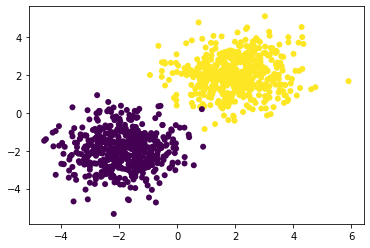

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

criterion = ClassNLLCriterion()



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

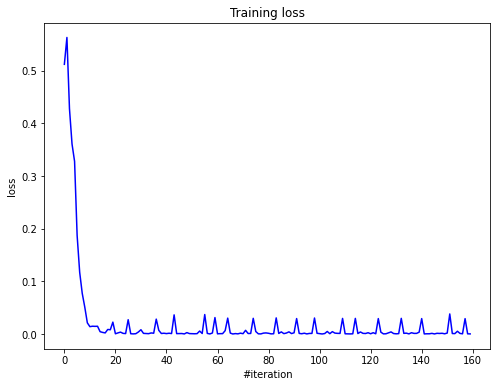

Current loss: 0.000208


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
y_train_oh = np.eye(10)[y_train.reshape(-1)]
y_val_oh = np.eye(10)[y_val.reshape(-1)]
y_test_oh = np.eye(10)[y_test.reshape(-1)]

x_train = X_train.reshape([len(X_train),-1])
x_val = X_val.reshape([len(X_val),-1])
x_test = X_test.reshape([len(X_test),-1])

In [10]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(50000, 784) (10000, 784) (10000, 784)
(50000,) (10000,) (10000,)


In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 128


Models

In [12]:
nn_relu = Sequential()
nn_relu.add(Linear(28*28, 128))
nn_relu.add(ReLU())
nn_relu.add(Linear(128,10))
nn_relu.add(LogSoftMax())
criterion_relu = ClassNLLCriterion()
print(nn_relu)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [13]:
nn_elu = Sequential()
nn_elu.add(Linear(28*28, 128))
nn_elu.add(ELU())
nn_elu.add(Linear(128,10))
nn_elu.add(LogSoftMax())
criterion_elu = ClassNLLCriterion()
print(nn_elu)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax



In [14]:
nn_soft = Sequential()
nn_soft.add(Linear(28*28, 128))
nn_soft.add(SoftPlus())
nn_soft.add(Linear(128,10))
nn_soft.add(LogSoftMax())
criterion_soft = ClassNLLCriterion()
print(nn_soft)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax



In [15]:
nn_leakyrelu = Sequential()
nn_leakyrelu.add(Linear(28*28, 128))
nn_leakyrelu.add(LeakyReLU())
nn_leakyrelu.add(Linear(128,10))
nn_leakyrelu.add(LogSoftMax())
criterion_leakyrelu = ClassNLLCriterion()
print(nn_leakyrelu)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax



- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

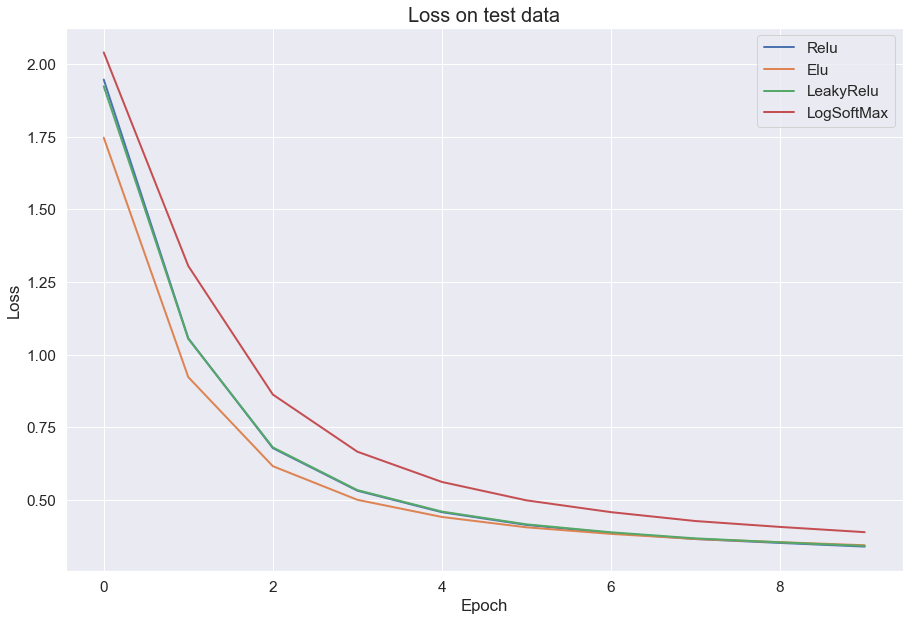

Duration of training for Relu is 13.74 s

Duration of training for Elu is 15.58 s

Duration of training for LeakyRelu is 14.27 s

Duration of training for LogSoftMax is 15.18 s


In [16]:
test_relu = []
test_elu = []
test_leakyrelu = []
test_soft = []

time_relu = 0
time_elu = 0
time_leakrelu = 0
time_soft = 0
    
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
        
        nn_relu.zeroGradParameters()
        
        time_relu_start = time()
        # Forward
        predictions_relu = nn_relu.forward(x_batch)
        loss_relu = criterion_relu.forward(predictions_relu, y_batch)
        # Backward
        dp_relu = criterion_relu.backward(predictions_relu, y_batch)
        nn_relu.backward(x_batch, dp_relu)
        sgd_momentum(nn_relu.getParameters(), 
                     nn_relu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_relu += time() - time_relu_start 
        
        nn_elu.zeroGradParameters()
        
        time_elu_start = time()
        # Forward
        predictions_elu = nn_elu.forward(x_batch)
        loss_elu = criterion_elu.forward(predictions_elu, y_batch)
        # Backward
        dp_elu = criterion_elu.backward(predictions_elu, y_batch)
        nn_elu.backward(x_batch, dp_elu)
        # Update weights
        sgd_momentum(nn_elu.getParameters(), 
                     nn_elu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_elu += time() - time_elu_start
        
        nn_leakyrelu.zeroGradParameters()
        
        time_leakrelu_start = time()
        # Forward
        predictions_leakrelu = nn_leakyrelu.forward(x_batch)
        loss_leakrelu = criterion_leakyrelu.forward(predictions_leakrelu, y_batch)
        # Backward
        dp_leakrelu = criterion_leakyrelu.backward(predictions_leakrelu, y_batch)
        nn_leakyrelu.backward(x_batch, dp_leakrelu)
        # Update weights
        sgd_momentum(nn_leakyrelu.getParameters(), 
                     nn_leakyrelu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_leakrelu +=  time() - time_leakrelu_start
        
        nn_soft.zeroGradParameters()
        
        time_soft_start = time()
        # Forward
        predictions_soft = nn_soft.forward(x_batch)
        loss_soft = criterion_soft.forward(predictions_soft, y_batch)
        # Backward
        dp_soft = criterion_soft.backward(predictions_soft, y_batch)
        nn_soft.backward(x_batch, dp_soft)
        # Update weights
        sgd_momentum(nn_soft.getParameters(), 
                     nn_soft.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_soft += time() - time_soft_start
        

    pred_test_relu = nn_relu.forward(x_test)
    test_relu.append(criterion_relu.forward(pred_test_relu, y_test_oh))

    pred_test_elu = nn_elu.forward(x_test)
    test_elu.append(criterion_elu.forward(pred_test_elu, y_test_oh))
    
    pred_test_leakrelu = nn_leakyrelu.forward(x_test)
    test_leakyrelu.append(criterion_leakyrelu.forward(pred_test_leakrelu, y_test_oh))
    
    pred_test_soft = nn_soft.forward(x_test)
    test_soft.append(criterion_soft.forward(pred_test_soft,y_test_oh))  
    
    
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(15, 10))
plt.title("Loss on test data", fontsize = 20)

plt.plot(range(n_epoch), test_relu, label="Relu", linewidth=2)
plt.plot(range(n_epoch), test_elu, label="Elu", linewidth=2)
plt.plot(range(n_epoch), test_leakyrelu, label="LeakyRelu", linewidth=2)
plt.plot(range(n_epoch), test_soft, label="LogSoftMax", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()   
        
print('Duration of training for Relu is {} s'.format(round(time_relu, 2)))
print()
print('Duration of training for Elu is {} s'.format(round(time_elu, 2)))
print()
print('Duration of training for LeakyRelu is {} s'.format(round(time_leakrelu, 2)))
print()
print('Duration of training for LogSoftMax is {} s'.format(round(time_soft, 2)))    
    
    

The worst activation function is considered Soft Plus, the rest are about the same

- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.

In [17]:
n_epoch = 10
batch_size = 128

In [18]:
nn_batch = Sequential()
nn_batch.add(Linear(28*28, 128))
nn_batch.add(BatchNormalization()) #alpha = 0.5
nn_batch.add(ChannelwiseScaling(128))
nn_batch.add(ReLU())
nn_batch.add(Linear(128,10))
#nn_batch.add(BatchNormalization(alpha = 0.5))
#nn_batch.add(ChannelwiseScaling(10))
nn_batch.add(LogSoftMax())
criterion_batch = ClassNLLCriterion()
print(nn_batch)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



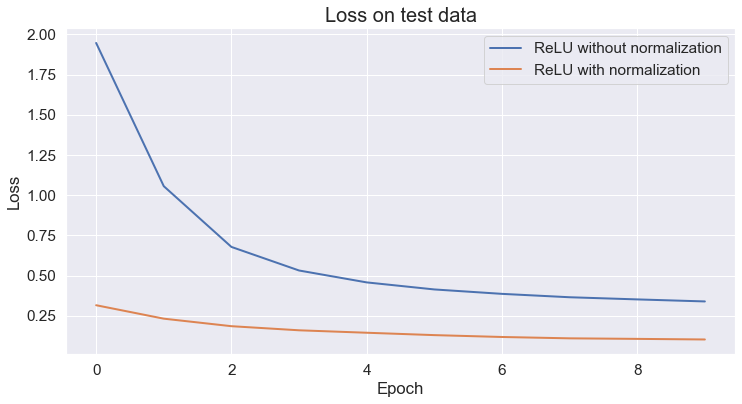

Current duration of training for ReLU without normalization is 13.74 s

Current duration of training for ReLU with normalization is 17.79 s


In [19]:
test_batch = []

time_batch = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
      
        nn_batch.zeroGradParameters()
        
        time_batch_start = time()
        predictions_batch = nn_batch.forward(x_batch)
        loss_batch = criterion_batch.forward(predictions_batch, y_batch)
        dp_batch = criterion_batch.backward(predictions_batch, y_batch)
        nn_batch.backward(x_batch, dp_batch)
        sgd_momentum(nn_batch.getParameters(), 
                      nn_batch.getGradParameters(), 
                       {'learning_rate' : 1e-1, 'momentum': 0.9},
                       {})
        
        time_batch += time() - time_batch_start
    
    pred_test_batch = nn_batch.forward(x_test)
    test_batch.append(criterion_batch.forward(pred_test_batch, y_test_oh))

                
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Loss on test data", fontsize = 20)

plt.plot(range(n_epoch), test_relu, label="ReLU without normalization", linewidth=2)
plt.plot(range(n_epoch), test_batch, label="ReLU with normalization", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()   
        
print('Current duration of training for ReLU without normalization is {} s'.format(round(time_relu, 2)))
print()
print('Current duration of training for ReLU with normalization is {} s'.format(round(time_batch, 2)))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Batch normalization achieves better convergence, the time is about the same. I think because the dataset is quite simple


- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [20]:
nn_adam = Sequential()
nn_adam.add(Linear(28*28, 128))
nn_adam.add(BatchNormalization(alpha=0.5)) #alpha=0.5
nn_adam.add(ChannelwiseScaling(128))
nn_adam.add(ReLU())
nn_adam.add(Linear(128,10))
nn_adam.add(BatchNormalization(alpha=0.5))
nn_adam.add(ChannelwiseScaling(10))
nn_adam.add(LogSoftMax())
criterion_adam = ClassNLLCriterion()
print(nn_adam)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax



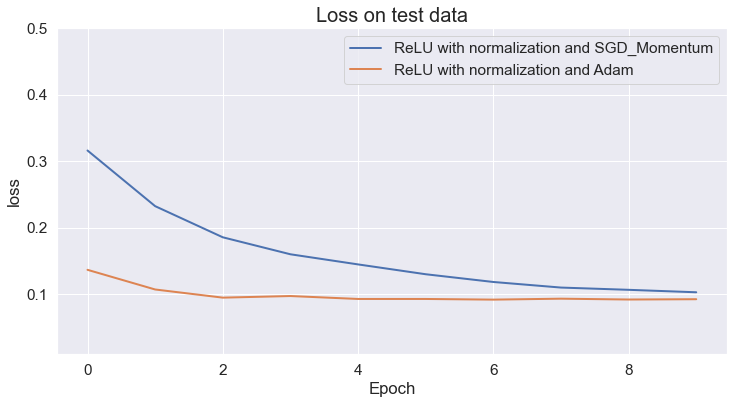

Current duration of training for ReLU with SGD_Momentum is 17.79 s

Current duration of training for ReLU with Adam is 28.15 s


In [21]:
test_adam = []

time_adam = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
        nn_adam.zeroGradParameters()
        
        time_adam_start = time()
        predictions_adam = nn_adam.forward(x_batch)
        loss_adam = criterion_adam.forward(predictions_adam, y_batch)
        dp_adam = criterion_adam.backward(predictions_adam, y_batch)
        nn_adam.backward(x_batch, dp_adam)
        adam_optimizer(nn_adam.getParameters(), 
                       nn_adam.getGradParameters(),
                       {'learning_rate' : 1e-2, 'beta1':0.9, 'beta2':0.99, 'epsilon': 1e-8},
                       {})
        
        time_adam += time() - time_adam_start 
        
    pred_test_adam = nn_adam.forward(x_test)
    test_adam.append(criterion_adam.forward(pred_test_adam, y_test_oh))

                
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Loss on test data", fontsize = 20)

plt.plot(range(n_epoch), test_batch, label="ReLU with normalization and SGD_Momentum", linewidth=2)
plt.plot(range(n_epoch), test_adam, label="ReLU with normalization and Adam", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim(0.01, 0.5)
plt.show()   
        
print('Current duration of training for ReLU with SGD_Momentum is {} s'.format(round(time_batch, 2)))
print()
print('Current duration of training for ReLU with Adam is {} s'.format(round(time_adam, 2)))

Adam Optimizer is superior to SGD in convergence, but I think it may lead to overfitting.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [22]:
nn_dropout = Sequential()
nn_dropout.add(Linear(28*28, 128))
nn_dropout.add(BatchNormalization(alpha=0.5)) 
nn_dropout.add(ChannelwiseScaling(128))
nn_dropout.add(Dropout(p=0.05))
nn_dropout.add(ReLU())
nn_dropout.add(Linear(128,10))
nn_dropout.add(BatchNormalization())
nn_dropout.add(ChannelwiseScaling(10))
nn_dropout.add(LogSoftMax())
criterion_dropout = ClassNLLCriterion()
print(nn_dropout)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
Dropout
ReLU
Linear 128 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax



In [23]:
n_epoch = 10
batch_size = 128

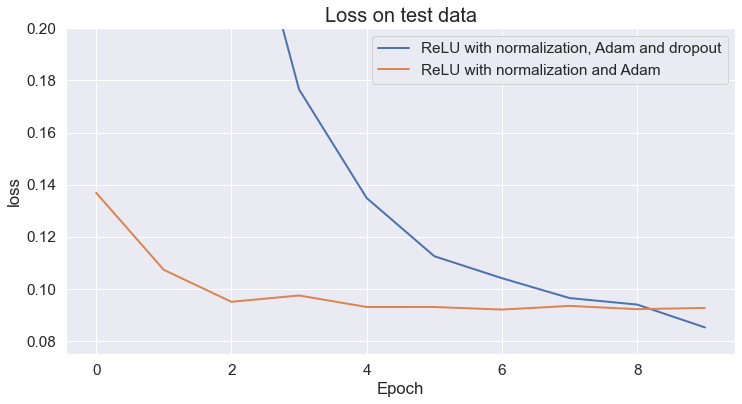

Current duration of training for ReLU with SGD and dropout is 24.09 s

Current duration of training for ReLU with Adam is 28.15 s


In [24]:
test_dropout = []

time_dropout = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train,y_train_oh), batch_size):
        nn_dropout.zeroGradParameters()
        
        time_dropout_start = time()
        predictions_dropout = nn_dropout.forward(x_batch)
        loss_dropout = criterion_dropout.forward(predictions_dropout, y_batch)
        dp_dropout = criterion_dropout.backward(predictions_dropout, y_batch)
        nn_dropout.backward(x_batch, dp_dropout)
        adam_optimizer(nn_dropout.getParameters(), 
                       nn_dropout.getGradParameters(),
                       {'learning_rate' : 1e-3, 'beta1':0.1, 'beta2':0.95, 'epsilon': 1e-6},
                       {})
                       
        time_dropout += time() - time_dropout_start 
        
    pred_test_dropout = nn_dropout.forward(x_test)
    test_dropout.append(criterion_dropout.forward(pred_test_dropout, y_test_oh))
    
    
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Loss on test data", fontsize = 20)

plt.plot(range(n_epoch), test_dropout, label="ReLU with normalization, Adam and dropout", linewidth=2)
plt.plot(range(n_epoch), test_adam, label="ReLU with normalization and Adam", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim(0.075, 0.2)
plt.show()   
        
print('Current duration of training for ReLU with SGD and dropout is {} s'.format(round(time_dropout, 2)))
print()
print('Current duration of training for ReLU with Adam is {} s'.format(round(time_adam, 2)))

            

In [25]:
nn_dropout_2 = Sequential()
nn_dropout_2.add(Linear(28*28, 128))
nn_dropout_2.add(BatchNormalization(alpha=0.5)) 
nn_dropout_2.add(ChannelwiseScaling(128))
nn_dropout_2.add(Dropout(p=0.05))
nn_dropout_2.add(ReLU())
nn_dropout_2.add(Linear(128,10))
nn_dropout_2.add(BatchNormalization())
nn_dropout_2.add(ChannelwiseScaling(10))
nn_dropout_2.add(LogSoftMax())
criterion_dropout_2 = ClassNLLCriterion()
print(nn_dropout_2)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
Dropout
ReLU
Linear 128 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax



### Let's see if increasing the epochs will give a better score

In [26]:
n_epoch = 15
batch_size = 128

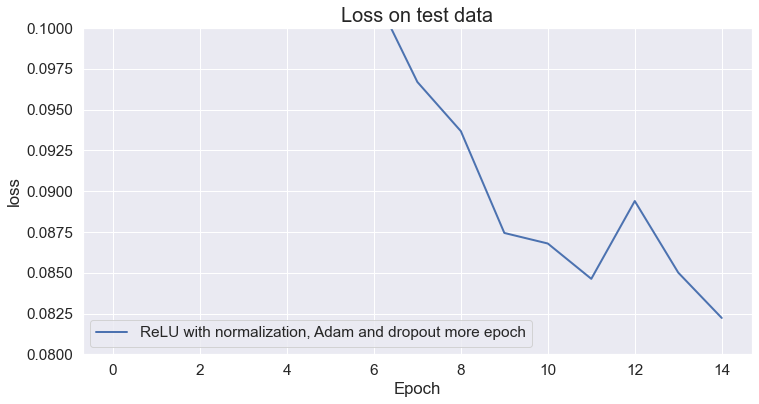

Current duration of training for ReLU with normalization, Adam and dropout more epoch is 30.7 s


In [27]:
test_dropout_2 = []

time_dropout_2 = 0

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
        nn_dropout.zeroGradParameters()
        
        time_dropout_start_2 = time()
        predictions_dropout_2 = nn_dropout_2.forward(x_batch)
        loss_dropout_2 = criterion_dropout_2.forward(predictions_dropout_2, y_batch)
        dp_dropout_2 = criterion_dropout_2.backward(predictions_dropout_2, y_batch)
        nn_dropout_2.backward(x_batch, dp_dropout_2)
        adam_optimizer(nn_dropout_2.getParameters(), 
                       nn_dropout_2.getGradParameters(),
                       {'learning_rate' : 1e-3, 'beta1':0.1, 'beta2':0.95, 'epsilon': 1e-6},
                       {})
                       
        time_dropout_2 += time() - time_dropout_start_2 
        
    pred_test_dropout_2 = nn_dropout_2.forward(x_test)
    test_dropout_2.append(criterion_dropout_2.forward(pred_test_dropout_2, y_test_oh))
    
    
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.title("Loss on test data", fontsize = 20)

plt.plot(range(n_epoch), test_dropout_2, label="ReLU with normalization, Adam and dropout more epoch", linewidth=2)


plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim(0.08, 0.1)
plt.show()   
        
print('Current duration of training for ReLU with normalization, Adam and dropout more epoch is {} s'.format(round(time_dropout_2, 2)))


Print here your accuracy on test set. It should be around 90%.

In [28]:
def accuracy(model):
    predictions = []
    predictions.append(model.forward(x_test))
    all_prediction = np.sum(predictions, axis=0)
    return np.argmax(all_prediction, axis=1)

In [29]:
result = []
for i in [nn_relu,nn_batch, nn_adam, nn_dropout, nn_dropout_2]:
    result.append((accuracy(i)== y_test).mean())

In [30]:
results = []
results.append(('ReLU without normalization', result[0],time_relu))
results.append(('ReLU with normalization', result[1],time_batch))
results.append(('ReLU with normalization and Adam', result[2],time_adam ))
results.append(('ReLU with normalization, Adam and dropout', result[3],time_dropout))
results.append(('ReLU with normalization, Adam and dropout more epoch', result[4],time_dropout_2))
results = pd.DataFrame(results, columns = ['Different Neural Network', 'Accuracy on test', 'Duration of training'])

In [31]:
results.style.highlight_max(['Accuracy on test'],color='yellow', axis = 0)

,Different Neural Network,Accuracy on test,Duration of training
0,ReLU without normalization,0.906800,13.737976
1,ReLU with normalization,0.970000,17.792160
2,ReLU with normalization and Adam,0.975200,28.152613
3,"ReLU with normalization, Adam and dropout",0.976700,24.088640
4,"ReLU with normalization, Adam and dropout more epoch",0.974900,30.704712


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [32]:
import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim
from matplotlib import gridspec

class ImgTransformation(object):
    def __init__(self):
        self.rotation_routine = transforms.Compose([
            transforms.ToPILImage(),
        ])
    
    def __call__(self, img):
        return np.array(self.rotation_routine(img))

class DatasetMNIST(Dataset):
    def __init__(self, data, labels):
        self.data, self.labels = data, labels
        self.img_transformation = ImgTransformation()
        
        self.side = int(self.data.shape[1]**.5)

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, index):

        image = self.data[index].astype(np.float32)
        label = self.labels[index]

        return image, label

In [33]:
class DatasetMNIST(Dataset):
    def __init__(self, data, labels):
        self.data, self.labels = data, labels
        self.img_transformation = transforms.Compose([transforms.ToPILImage()])
        
        self.side = int(self.data.shape[1]**.5)

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, index):

        image = self.data[index].astype(np.float32)
        label = self.labels[index]

        return image, label

In [34]:
train_dataloader = torch.utils.data.DataLoader(DatasetMNIST(x_train, y_train), batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(DatasetMNIST(x_test, y_test), batch_size=128, shuffle=False)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
model = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.BatchNorm1d(128, momentum=0.5),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

In [37]:
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            100,480
├─BatchNorm1d: 1-2                       256
├─ReLU: 1-3                              --
├─Dropout: 1-4                           --
├─Linear: 1-5                            1,290
├─LogSoftmax: 1-6                        --
Total params: 102,026
Trainable params: 102,026
Non-trainable params: 0

In [38]:
#check
batch = next(iter(train_dataloader))
model.forward(torch.FloatTensor(batch[0]))

tensor([[-2.9605, -2.9794, -2.5976,  ..., -3.1776, -1.6993, -2.8605],
        [-2.0212, -2.3696, -2.4798,  ..., -2.4971, -2.5103, -2.7236],
        [-2.3115, -2.2311, -1.8009,  ..., -2.6049, -1.9385, -2.6130],
        ...,
        [-2.2660, -2.0901, -2.4024,  ..., -2.4232, -1.9969, -2.5221],
        [-1.9081, -2.4700, -2.4377,  ..., -2.1279, -2.2842, -2.5848],
        [-3.0013, -2.6763, -1.5592,  ..., -3.0252, -2.1866, -2.1842]],
       grad_fn=<LogSoftmaxBackward0>)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99))
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)
max_epochs = 10
loaders = {"train": train_dataloader, "valid": val_dataloader}

In [40]:
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [41]:
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.92092
Loader: valid. Accuracy: 0.9584
Epoch: 2
Loader: train. Accuracy: 0.95688
Loader: valid. Accuracy: 0.9711
Epoch: 3
Loader: train. Accuracy: 0.96584
Loader: valid. Accuracy: 0.971
Epoch: 4
Loader: train. Accuracy: 0.97156
Loader: valid. Accuracy: 0.9745
Epoch: 5
Loader: train. Accuracy: 0.97476
Loader: valid. Accuracy: 0.975
Epoch: 6
Loader: train. Accuracy: 0.97686
Loader: valid. Accuracy: 0.9783
Epoch: 7
Loader: train. Accuracy: 0.97994
Loader: valid. Accuracy: 0.9792
Epoch: 8
Loader: train. Accuracy: 0.9808
Loader: valid. Accuracy: 0.9766
Epoch: 9
Loader: train. Accuracy: 0.98308
Loader: valid. Accuracy: 0.9784
Epoch: 10
Loader: train. Accuracy: 0.98364
Loader: valid. Accuracy: 0.979
